# README

**Goal:**

Model a distance sensor and velocity sensor measuring a droplet of herbicide as it is sprayed downward toward the ground. Use a Kalman Filter to improve the measurement, and compare the results of the Kalman filter with the raw measurements.

**Assumptions:**

- All Kalman Filter error matrices are set to zero (except measurement error).

In [1]:
import numpy as np
import random as rnd
import math as m
import matplotlib.pyplot as plt
import kalmanFilter as kf

### Global Variables

In [2]:
tstep = 0.001 # sec, 1kHz
g = -9.81 # m/s^2

# Sprayer properties
sprayHeight = 2 # m
sprayVelocity = -1 # m/s

### Set Initial Conditions

In [3]:
# Distance sensor initial value and StDev error
z0 = sprayHeight # m
z_stdev = 0.05 # m

# Speed sensor initial value and StDev error
vz0 = sprayVelocity # m/s
vz_stdev = 0.1 # m/s

# Process errors for process covariance matrix
z_proc_stdev = 0.02 # m
vz_proc_stdev = 0.05 # m/s

# Calculate covariance of z and vz for MEASUREMENTS
z_vz_covar_meas = z_stdev * vz_stdev
# Calculate covariance of z and vz for PROCESS
z_vz_covar_proc = z_proc_stdev * vz_proc_stdev

# Previous state matrix
Xkp_prev = np.array([[z0],[vz0]])

# Previous process covariance matrix
Pkp_prev = np.array([[z_proc_stdev**2, z_vz_covar_proc],[z_vz_covar_proc, vz_proc_stdev**2]])

# FOR KALMAN FILTER TO WORK, PROCESS VARIANCES MUST BE LESS THAN SENSOR VARIANCES.
# IF THE SAME VARIANCES ARE USED FOR PROCESS AND MEASUREMENTS, THE KALMAN FILTER
# WILL HAVE NO EFFECT BECAUSE IT WILL INTRODUCE AS MUCH ERROR INTO THE CALCULATION
# FROM PHYSICS PREDICTION AS THE SENSORS WILL INTRODUCE, SO THERE IS NO BENEFIT.

# u Matrix
uk = np.array([[g]]) # m/s^2

# A Matrix
A = np.array([[1,tstep],[0,1]])
# B Matrix
B = np.array([[0.5*(tstep**2)],[tstep]])
# C Matrix
C = np.identity(2)
# H Matrix
H = np.identity(2)
# R Matrix
R = np.array([[z_stdev**2, z_vz_covar_meas],[z_vz_covar_meas, vz_stdev**2]]) # How is this different from Pkp?

# Process error matrices (incorporate later)
wk = np.array([[0]])
ZR = np.array([[0]])
QR = np.array([[0]])

Generate time series, and true distance and velocity values

Text(0.5, 1.0, 'True Distance and Velocity')

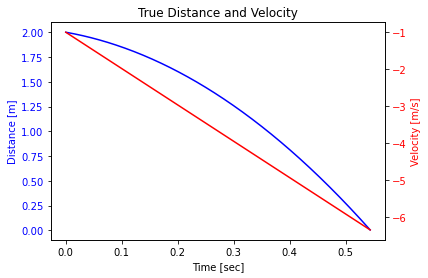

In [4]:
# Calculate time it will take droplet to hit the ground
soln1 = (-vz0 + m.sqrt((vz0**2) - (2*g*sprayHeight))) / g
soln2 = (-vz0 - m.sqrt((vz0**2) - (2*g*sprayHeight))) / g
dropTime = max(soln1, soln2)

# Time series
t = np.arange(0, dropTime, tstep)

# True droplet vertical position (off ground)
z = np.array([])
for i in t:
    z = np.append(z, (z0 + (vz0 * i) + (0.5 * g * (i**2))))
fig, ax1 = plt.subplots()
ax1.plot(t, z, color='blue', label='True Distance [m]')
ax1.set_xlabel('Time [sec]')
ax1.set_ylabel('Distance [m]', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# True velocity values
vz = np.array([])
for i in t:
    vz = np.append(vz, (vz0 + (g * i)))
ax2 = ax1.twinx()
ax2.plot(t, vz, color='red', label='True Velocity [m/s]')
ax2.set_ylabel('Velocity [m/s]', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('True Distance and Velocity')

Function to generate distance sensor data:

In [5]:
# trueValue = true distance of droplet from sprayer
# noiseStdev = standard deviation of sensor noise
def generateDistanceSensorData(trueValue, noiseStDev):
    # Technically distance sensor value would be inverted relative to
    # distance off ground, but let's assume distance sensor outputs
    # distance off ground for simplicity.
    noise = rnd.gauss(0, noiseStDev)
    sensorOutput = trueValue + noise
    return sensorOutput

Function to generate speed sensor data:

In [6]:
# trueValue = true velocity of droplet
# noiseStdev = standard deviation of sensor noise
def generateVelocitySensorData(trueValue, noiseStDev):
    noise = rnd.gauss(0, noiseStDev)
    sensorOutput = trueValue + noise
    return sensorOutput

Test generated distance sensor data

Text(0.5, 1.0, 'Generated Distance Sensor Data')

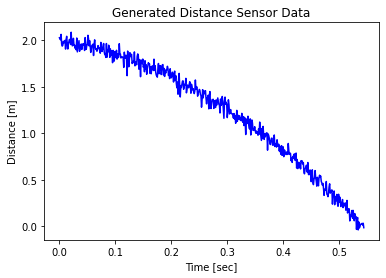

In [7]:
distance = np.array([])
for i in range(len(t)):
    x = generateDistanceSensorData(z[i], z_stdev)
    distance = np.append(distance, x)
fig, ax1 = plt.subplots()
ax1.plot(t, distance, color='blue')
ax1.set_xlabel('Time [sec]')
ax1.set_ylabel('Distance [m]')
plt.title('Generated Distance Sensor Data')

Test generated speed sensor data

Text(0.5, 1.0, 'Generated Velocity Sensor Data')

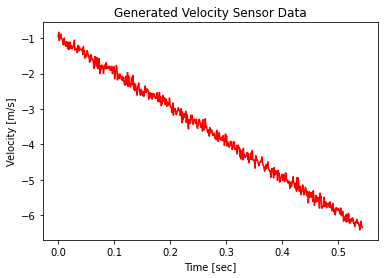

In [8]:
velocity = np.array([])
for i in range(len(t)):
    x = generateVelocitySensorData(vz[i], vz_stdev)
    velocity = np.append(velocity, x)
fig, ax1 = plt.subplots()
ax1.plot(t, velocity, color='red')
ax1.set_xlabel('Time [sec]')
ax1.set_ylabel('Velocity [m/s]')
plt.title('Generated Velocity Sensor Data')

Run Kalman filter

In [9]:
# In these arrays, first column is true value, second is predicted value, third is measured value, last is filtered value.
distance = np.array([[0,0,0,0]])
velocity = np.array([[0,0,0,0]])

for i in range(len(t)):
    # Receive new simulated measurements.
    # Use sensor measurement stdev's to introduce noise.
    newDist = generateDistanceSensorData(z[i], z_stdev)
    newVel = generateVelocitySensorData(vz[i], vz_stdev)
    Ykm = np.array([[newDist],[newVel]])
    # Calculate values for Kalman filter equation
    Xkp = kf.nextPredictState(A, Xkp_prev, B, uk, wk)
    Pkp = kf.predictProcCovar(A, Pkp_prev, QR)
    K = kf.kalmanGain(Pkp, H, R)
    Yk = kf.newMeas(C, Ykm, ZR)
    # Run Kalman Filter equation
    Xk = kf.filterEqn(Xkp, K, Yk, H)
    # Update process covariance matrix
    Pk = kf.updateProcCovar(np.identity(2), K, H, Pkp)
    # Save results for graphing
    distance = np.append(distance, [[z[i], Xkp[0,0], Ykm[0,0], Xk[0,0]]], axis=0)
    if(i == 0):
        # Delete placeholder first element
        distance = np.delete(distance, 0, axis=0)
    velocity = np.append(velocity, [[vz[i], Xkp[1,0], Ykm[1,0], Xk[1,0]]], axis=0)
    if(i == 0):
        # Delete placeholder first element
        velocity = np.delete(velocity, 0, axis=0)
    # Current values become previous for next cycle
    Xkp_prev = Xkp
    Pkp_prev = Pkp

Plot distance results

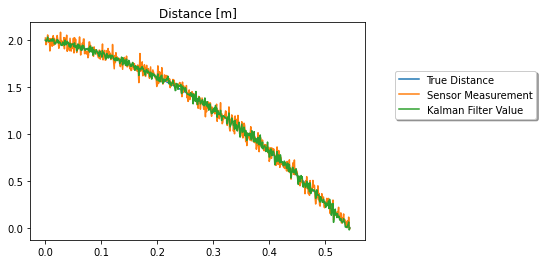

In [10]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
ax.plot(t, distance[:,0], label='True Distance')
#ax.plot(t, distance[:,0], label='Predicted by Physics')
ax.plot(t, distance[:,2], label='Sensor Measurement')
ax.plot(t, distance[:,3], label='Kalman Filter Value')
plt.title('Distance [m]')
ax.legend(loc='upper center', bbox_to_anchor=(1.3, 0.8), shadow=True, ncol=1)
plt.show()

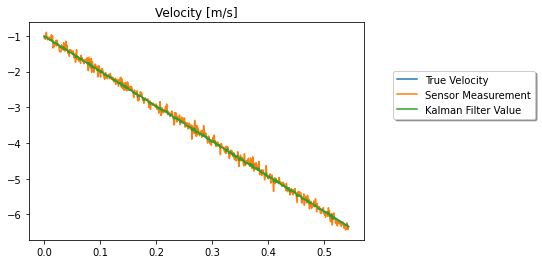

In [11]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
ax.plot(t, velocity[:,0], label='True Velocity')
#ax.plot(t, velocity[:,0], label='Predicted by Physics')
ax.plot(t, velocity[:,2], label='Sensor Measurement')
ax.plot(t, velocity[:,3], label='Kalman Filter Value')
plt.title('Velocity [m/s]')
ax.legend(loc='upper center', bbox_to_anchor=(1.3, 0.8), shadow=True, ncol=1)
plt.show()